## Notebook to obtain the ERA5 and 20CRv3 datasets containing the pressure gradient

Tide gauge observations for the Dutch coast are obtained from the Permanent Service for Mean Sea Level (PSMSL, https://www.psmsl.org) and are adjusted to the Revised Local Reference datum

Sea level pressure data were obtained from ERA5 and 20CR reanalyses. See notebook *prepare_atmospheric_data.ipynb* for more details on how to download the data.
   
   

In [1]:
# Import packages

import numpy as np
import xarray as xr
import pandas as pd
import regionmask

import cartopy.crs as ccrs
#import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import statsmodels.tsa.tsatools

In [2]:
# For higher resolution images on retina display screens

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


In [3]:
#path_data = '/Users/iriskeizer/Documents/Wind effect/paper/code check/data/'
path_data = '/Users/dewilebars/Projects/SLBudget/data'

path_pres_data = f'{path_data}/WindPressure'
tg_data_dir = f'{path_data}/rlr_annual'

output_dir = './data_atmosphere'

stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']

In [4]:
def tide_gauge_obs(interp=True):
    '''
    Read a list of tide gauge data and compute the average. 
    Set interp to True for a linear interpollation of missing values.
    By default use the 6 tide gauges from the Zeespiegelmonitor.
    The unit of the output is cm. ''' 
    tg_id=[20, 22, 23, 24, 25, 32]
    
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', 
                              header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')

    names_col2 = ('time', 'height', 'interpolated', 'flags')

    for i in range(len(tg_id)):
        tg_data = pd.read_csv(f'{tg_data_dir}/data/{tg_id[i]}.rlrdata', 
                              sep=';', header=None, names=names_col2)
        tg_data = tg_data.set_index('time')
        tg_data.height = tg_data.height.where(~np.isclose(tg_data.height,-99999))
        tg_data.height = tg_data.height - tg_data.height.mean()

        if i==0:
            tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, 
                                                col_name=tg_data.height))
            tg_data_df = tg_data_df.set_index('time')
            tg_data_df.columns  = [str(tg_id[i])] 
        else:
            tg_data_df[str(tg_id[i])] = tg_data.height

    if interp:
        tg_data_df = tg_data_df.interpolate(method='slinear')
        
    tg_data_df['Average'] = tg_data_df.mean(axis=1)
    tg_data_df = tg_data_df * 0.1 # Convert from mm to cm
    
    # Rename columns to station names
    tg_data_df = tg_data_df.rename(columns={"20": stations[0], 
                              "22": stations[1], "23": stations[2],
                              "24": stations[3], "25": stations[4],
                              "32": stations[5]})
    
    
    
    return tg_data_df

In [5]:
tg_df = tide_gauge_obs()

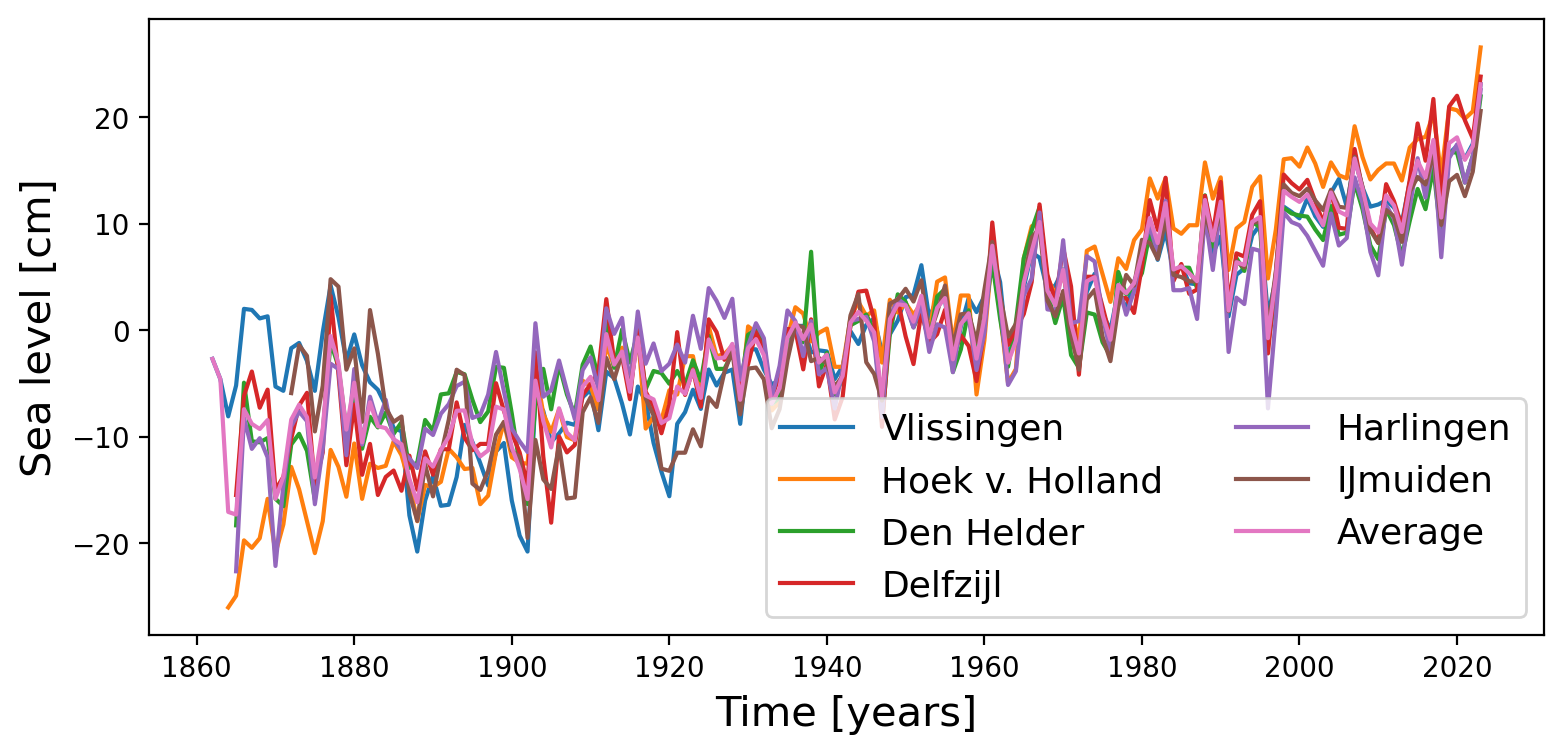

In [6]:
ax = tg_df.plot(figsize = (9,4))
ax.set_xlabel('Time [years]', fontsize = 15)
ax.set_ylabel('Sea level [cm]', fontsize = 15)
ax.legend(fontsize = 13, loc = 'lower right', ncol = 2)

### Process sea-level pressure data



In [7]:
def prep_pres_data_obs(data_type = 'era5'):
    """ Function to prepare the observational pressure data for the analysis. For data_type choose ['era5', '20cr']  """
    
    if data_type == 'era5':
        
        timen = 'valid_time'
        
        # Define the path to code
        path_sp = f'{path_pres_data}/ERA5/ERA5_msl.nc'
        
        # Open data file
        dataset_sp = xr.open_dataset(path_sp) 

        # Change coordinate and variable names
        dataset_sp = dataset_sp.rename({'longitude': 'lon','latitude': 'lat','msl': 'pressure'})

        # Sort latitudes increasing
        dataset = dataset_sp.sortby('lat')

        
    elif data_type == '20cr':
        
        timen = 'time'
        
        # Open data file
        dataset = xr.open_dataset(path_pres_data + '/20CR/prmsl.mon.mean.nc') 

        # Shift longitudes to -180-180 
        dataset.coords['lon'] = (dataset.coords['lon'] + 180) % 360 - 180
        dataset = dataset.sortby(dataset.lon)

        # Change coordinate and variable names
        dataset = dataset.rename({'prmsl': 'pressure'})
    
        #Drop 'time_bnds' variables
        dataset = dataset.drop('time_bnds')
        
        # Select smaller area of data 
        dataset = dataset.where((dataset.lat >= 0) & (dataset.lat <= 90) & (dataset.lon >= -90) & (dataset.lon <= 90), drop=True)

    else: print('Given data_type not correct, choose era5 or 20cr')

        
    # Calculate annual averages 
    dataset_annual = dataset.groupby(f'{timen}.year').mean(timen)
   
    # Save annual data as netcdf4  
    #dataset_annual.to_netcdf(f'{path_pres}pres_annual_{data_type}')
    
    
    return dataset_annual
    


### Import and calculate annual averages of ERA5 reanalysis data of pressure fields

In [8]:
pres_data_era5 = prep_pres_data_obs()

In [9]:
pres_data_era5

<xarray.Dataset>
Dimensions:   (lat: 241, lon: 321, year: 84)
Coordinates:
    number    int64 0
  * lat       (lat) float64 20.0 20.25 20.5 20.75 21.0 ... 79.25 79.5 79.75 80.0
  * lon       (lon) float64 -30.0 -29.75 -29.5 -29.25 ... 49.25 49.5 49.75 50.0
  * year      (year) int64 1940 1941 1942 1943 1944 ... 2019 2020 2021 2022 2023
Data variables:
    pressure  (year, lat, lon) float32 1.017e+05 1.017e+05 ... 1.01e+05 1.01e+05

### Import and calculate annual averages of 20th century reanalysis data of pressure fields

In [10]:
pres_data_20cr = prep_pres_data_obs(data_type = '20cr')

### Obtain the pressure gradient data sets

In [11]:
def import_pres_tg_corr_data(dataset_annual, deg = 3, time_min = 1950, time_max = 2015):
    '''
    
    Function to import the pressure and tide gauge data in order to perform the correlation. '''

    # Prepare pressure data

    # Import annual pressure data
    pres = dataset_annual 

    # Detrend
    pres_corr = pres.pressure - xr.polyval(pres.year, pres.pressure.polyfit(dim = 'year', deg = deg).polyfit_coefficients)
    
    # Rename year to time
    pres_corr = pres_corr.rename({'year':'time'})
    
    
    
    # Prepare tide gauge data

    # Import tide gauge data from 1890 onwards
    tg = tide_gauge_obs().loc[1890:]

     # Detrend and create list
    data = []

    for station in tg.columns:
        data.append(statsmodels.tsa.tsatools.detrend(tg[station].values, order=deg, axis = 0))
        

    # Create dataarray of tide gauge data
    tg_corr = xr.DataArray(data, dims = ['station', 'time'], coords = dict(time = tg.index, station = tg.columns))
    
    
    # Make time periods equal
    pres_corr = pres_corr.where((pres_corr.time >= time_min) & (pres_corr.time <= time_max), drop = True)
    tg_corr = tg_corr.where((tg_corr.time >= time_min) & (tg_corr.time <= time_max), drop = True)
    
    return pres_corr, tg_corr

In [12]:
pres_corr_era5, tg_corr_era5 = import_pres_tg_corr_data(pres_data_era5, time_min = 1950, time_max = 2020)
pres_corr_20cr, tg_corr_20cr = import_pres_tg_corr_data(pres_data_20cr, time_min = 1890, time_max = 2015)

In [13]:
def dangendorf_regions_plot(pres_corr, tg_corr, data_type):
    '''
    Function that plots a map of the North Atlantic region indicating the locations of the positive and negative correlation region
    '''
    fsize = 13
    
    
    
    # Obtain correlation
    corr = xr.corr(pres_corr, tg_corr, dim='time')
    
    corr.to_netcdf(f'./outputs/corr_{data_type}.nc')

    # Select proxy region
    dang_coords_np = np.array([[-0.1, 54.9], [40.1, 54.9], [40.1, 75.1], [-0.1, 75.1]])
    dang_coords_pp = np.array([[-20.1, 24.9], [20.1, 24.9], [20.1, 45.1], [-20.1, 45.1]])

    dang_regions = regionmask.Regions([dang_coords_np, dang_coords_pp], numbers = [1,2], 
                                          names=["", ""], abbrevs=["NP", "PP"], 
                                          name="Dangendorf regions")

    # Plot the map
    fig = plt.figure(figsize=(8,16))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_extent([-35, 45, 20, 80], crs=ccrs.PlateCarree())
    #ax.axis('off')
    plot = corr.sel(station = 'Average').plot(ax=ax, transform = ccrs.PlateCarree(), vmin = -0.6, vmax = 0.6, 
                                              cmap = 'RdBu_r', add_colorbar=False)
    cb = plt.colorbar(plot, orientation="vertical", shrink = 0.35, extend = 'both')                                   
    cb.set_label(label='Correlation coefficient', size=15)
    cb.ax.tick_params(labelsize=15)    
    if data_type == 'ERA5':
        ax.set_title('Pressure data = ERA5', fontsize = 15)
    elif data_type == '20CR':
        ax.set_title('Pressure data = 20CRv3', fontsize = 15)
    ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    gl.ylocator = mticker.FixedLocator([30, 40, 50, 60, 70])
    gl.xlocator = mticker.FixedLocator([-20, 0, 20, 40])
    
    
    # Add axes labels
    #plt.text(-10, 10, 'Longitude [°]', fontsize = 15)
    #plt.text(-30, 40, 'Latitude [°]', fontsize = 15, rotation='vertical')
    
    
    dang_regions.plot(ax = ax, label = 'name', line_kws = {'color':'snow', 'lw':3.1}, text_kws = dict(bbox=dict(color="none"), fontsize = 15, color = 'snow'))

    
    plt.savefig(f'./figures/corr_map_{data_type}', bbox_inches='tight', dpi = 150)
    
   

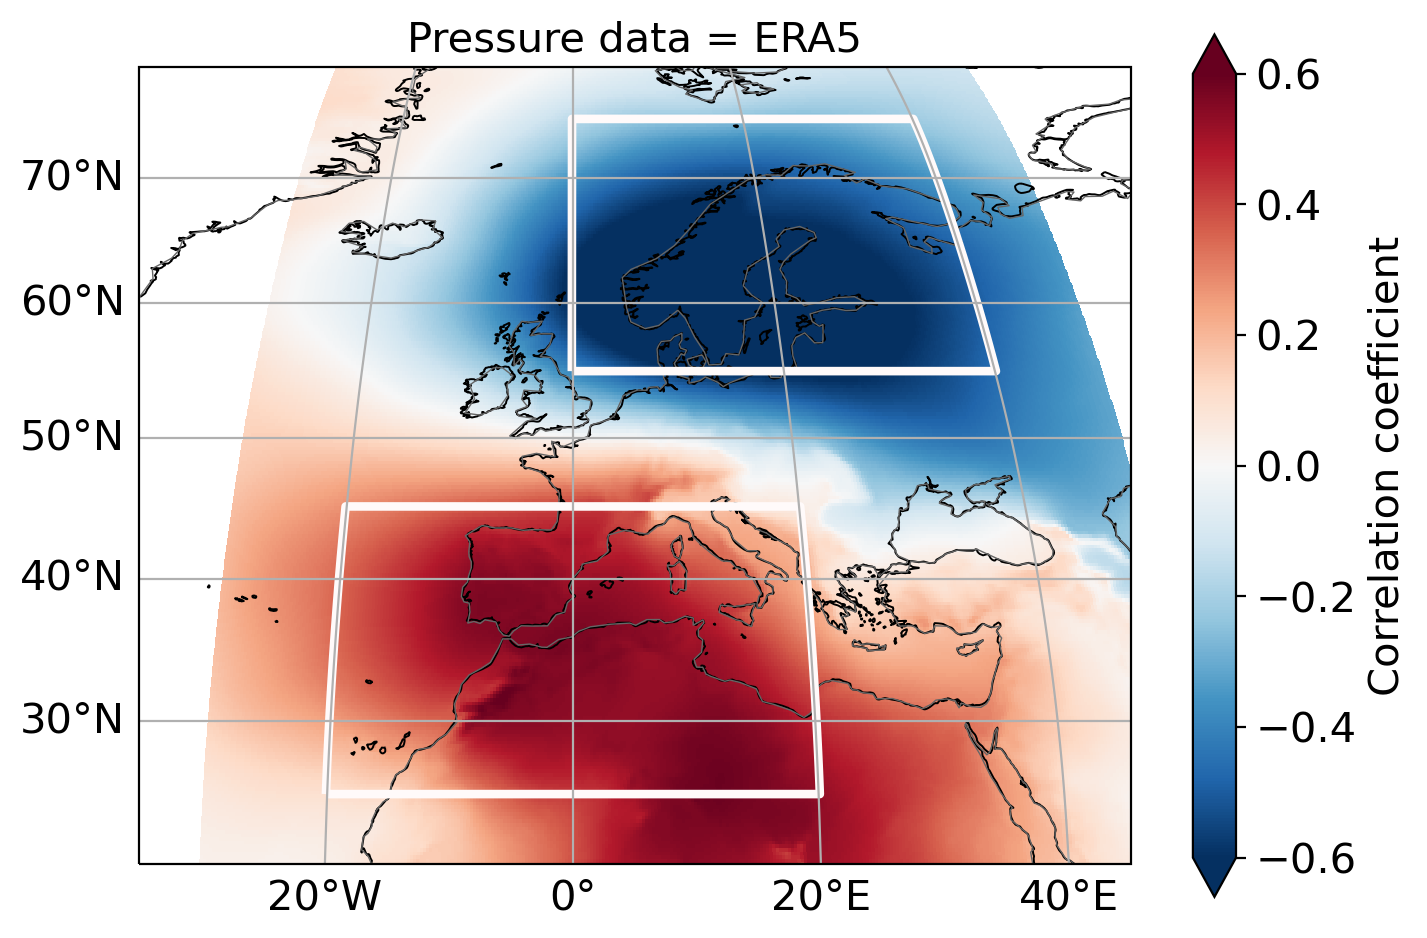

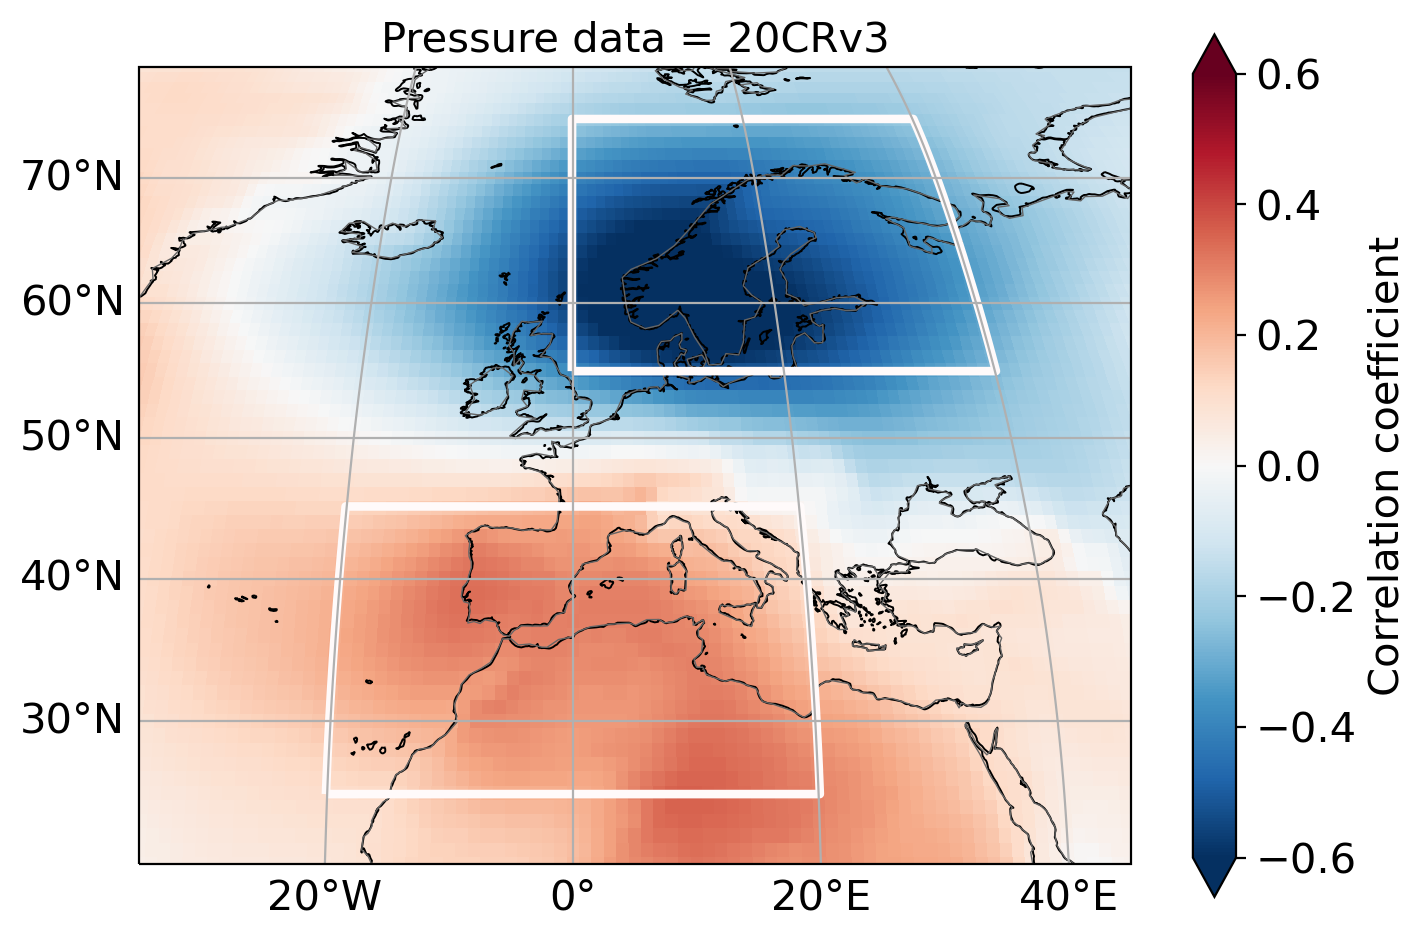

In [14]:
dangendorf_regions_plot(pres_corr_era5, tg_corr_era5, 'ERA5')
dangendorf_regions_plot(pres_corr_20cr, tg_corr_20cr, '20CR')

In [15]:
def get_proxies(pres):
    '''Function to obtain the atmospheric proxies. '''
    
    # Select proxy region
    dang_coords_np = np.array([[-0.1, 54.9], [40.1, 54.9], [40.1, 75.1], [-0.1, 75.1]])
    dang_coords_pp = np.array([[-20.1, 24.9], [20.1, 24.9], [20.1, 45.1], [-20.1, 45.1]])
        
    
    dang_regions = regionmask.Regions([dang_coords_np, dang_coords_pp], numbers = [1,2], 
                                      names=["Negative proxy", "Positive proxy"], abbrevs=["NP", "PP"], 
                                      name="Dangendorf regions")

    
    # Create wind data array per region
    mask = dang_regions.mask(pres)

    regional_data = []  # List containing the dataset per region
    

    for i in range(1,3):
        regional_data.append(pres.where(mask == i, drop=True)) 

    # Obtain spatial averages of proxy region
    slp_mean = [] # List containing the average per region

    for idx, val  in enumerate(regional_data):
        slp_mean.append(val.mean(dim=['lon','lat']))

    
        
    return slp_mean


def process_pres(dataset_annual):
    '''Function to process the pressure data. data_type = 'ERA5' or '20CR'. '''
   
    pres_data = get_proxies(dataset_annual) # List containing two xarray.datasets
        
    # Create dataframe
    annual_df = pd.DataFrame(data={'time': pres_data[1].year, 
                                       'Negative corr region' : pres_data[0].pressure.values, 
                                       'Positive corr region' : pres_data[1].pressure.values})
    annual_df =  annual_df.set_index('time')
    
    
    return annual_df, dataset_annual

In [16]:
pres_era5, pres_era5_ds = process_pres(pres_data_era5)
pres_20cr, pres_20cr_ds = process_pres(pres_data_20cr)

In [17]:
pres_era5.to_csv(f'{output_dir}/dangendorf_era5_wind_data.csv')
pres_20cr.to_csv(f'{output_dir}/dangendorf_20cr_wind_data.csv')